In [7]:
import numpy as np
import sys
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import utilities as utils

#tag = "A-0.5_"
tag = "A-0.75_"
#tag = ""

onecol = 3.42
onep5 = 4.5
twocol = 7

ext = ".jpg"

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 8
plt.rcParams['lines.linewidth'] = 1.5

color1 = (.6,.06,.06)
color2 = (.42,.6,.06)
color3 = (.15,.06,.6)
def symm(x):
    return (x + x.T)/2


def rec(x):
    return (x + np.abs(x))/2

def v_std(f,meanax = 0,indices = [0,1],axis =-1):
    
    return np.take(np.std(f,axis = meanax),indices,axis)

def boot_f(func,f,bootax = 1,nboot = 1000):
    ind = [np.random.choice(range(f.shape[bootax]),f.shape[bootax]) for k in range(nboot)]

    rr = [func(np.take(f,ind[i],bootax)) for i in range(len(ind))]
    print(np.array(rr).shape)
    std = np.std(rr,0)
    
    return std

def resp_std(f,axis = -1,square = False,indices = [0,1],meanfirst = True,meanax = 0,nboot = 1000):
   
    ind = [np.random.choice(range(f.shape[meanax[0]]),f.shape[meanax[0]]) for k in range(nboot)]

    rr = [resp(np.take(f,ind[i],meanax[0]),axis,square,indices,meanfirst,meanax) for i in range(len(ind))]

    std = np.std(rr,0)
    
    return std

def resp(f,axis = -1,square = False,indices = [0,1],meanfirst = True,meanax = 0):
    if meanfirst:
        r = np.mean(f,axis = meanax,keepdims = True)
    else:
        r = np.copy(f)
    
    R = 0
    
    for i in indices:
        R += rec(np.take(r,i,axis = axis))**2
    
    R = np.mean(R,meanax)
    
    if square == False:
        R = np.sqrt(R)

    return R

def trans(x):
    y = [a for a in x]
    y[-1] = .2
    return tuple(y)

def fill_between(ax,x,mean,std,color):
    ax.fill_between(x,mean - std,mean + std,color = trans(color))
    
    

# Parameterized Model
- additivity index by width and SNR

(6, 10, 10, 50)


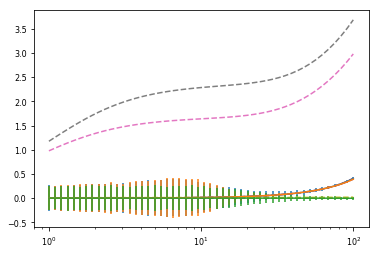

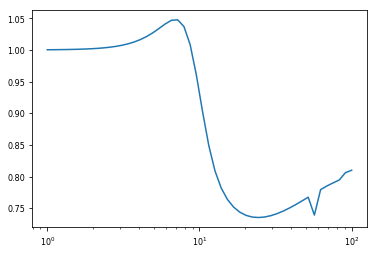

(600, 6, 10, 10, 50)
(10,)
(10, 10, 50)
('II', 0)


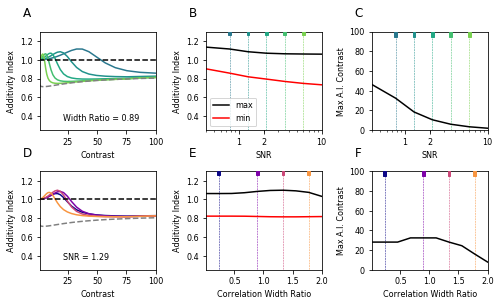

(10,)


In [1112]:
from scipy.ndimage.filters import gaussian_filter as gfilt

#Pdat_M = np.apply_along_axis(lambda x:gfilt(x,2),3,np.array([np.mean(rect(np.array([x[i] for x in Pdat])),axis = 0) for i in range(len(Pdat[0]))]))
#Pdat_M = np.array([np.mean(rect(np.array([x[i] for x in Pdat])),axis = 0) for i in range(len(Pdat[0]))])
Pdat_S = np.array([np.std(rect(np.array([x[i] for x in Pdat])),axis = 0) for i in range(len(Pdat[0]))])
    
print(Pdat_M.shape)

plt.errorbar(np.logspace(0,2,Pdat_M.shape[3]),Pdat_M[0,6,1],yerr = Pdat_S[0,3,-1])
plt.errorbar(np.logspace(0,2,Pdat_M.shape[3]),Pdat_M[1,6,1],yerr = Pdat_S[1,3,-1])
plt.errorbar(np.logspace(0,2,Pdat_M.shape[3]),Pdat_M[2,6,1],yerr = Pdat_S[2,3,-1])

plt.plot(np.logspace(0,2,Pdatn.shape[3]),Pdatn[0,6,1],"--")
plt.plot(np.logspace(0,2,Pdatn.shape[3]),Pdatn[1,6,1],"--")
plt.plot(np.logspace(0,2,Pdatn.shape[3]),Pdatn[2,6,1],"--")

plt.plot(np.logspace(0,2,Pdatn.shape[3]),Pdatn[3,6,1],"--")
plt.plot(np.logspace(0,2,Pdatn.shape[3]),Pdatn[4,6,1],"--")
plt.plot(np.logspace(0,2,Pdatn.shape[3]),Pdatn[5,6,1],"--")
plt.xscale("log", nonposx='clip')

#plt.xlim([1,2])
#plt.ylim([-.1,.5])
plt.show()

plt.plot(np.logspace(0,2,Pdat_M.shape[3]),Pdat_M[0,3,-1]/(Pdat_M[1,3,-1]+Pdat_M[2,3,-1]))
plt.xscale("log", nonposx='clip')
plt.show()

print(Pdat.shape)

NUM_CURVE = 10
NUM_CON = 50
NUM_W = 20

CMAX = 1.
CMIN = -2.
N = 8

plt.clf()

kcm = plt.get_cmap('viridis')
wcm = plt.get_cmap('plasma')

WW = np.logspace(-1,1,NUM_CURVE)
wval = np.linspace(.01,2,10)
con = np.logspace(CMIN,CMAX,NUM_CON)
con = 100 * con / np.max(con)

AI = Pdat_M[0]/(Pdat_M[1]+Pdat_M[2])
nAI = Pdatn[3]/(Pdatn[4]+Pdatn[5])

print(WW.shape)
print(AI.shape)

fig,sub = plt.subplots(2,3,figsize = (twocol,twocol*2/3))

#sub[0,0].axis("off")
#sub[0,1].axis("off")
##Kvary
kwi = 4
wki = 5

kind = range(len(WW))[4:-1]

ax = sub[0,0]
ax.set_prop_cycle("color",[kcm(1.*i/(len(WW))) for i in kind])#AI.shape[0]-1)])

for i in kind:#range(0,AI.shape[1]-1,1):
    if i == wki and False:
        ax.plot(con,AI[kwi,i],linewidth=3)
    else:
        ax.plot(con,AI[kwi,i],linewidth = 1.5)

ax.plot(con,np.ones_like(con),"k--")
ax.plot(con,nAI[kwi,-1],"--",color=(.5,.5,.5))
ax.set_xlim([1,100])
ax.set_ylim([.25,1.3])
ax.set_xlabel("Contrast")
ax.set_ylabel("Additivity Index")
ax.text(-.15, 1.15, "A", fontsize=12,transform =ax.transAxes)
ax.text(.2, .1, "Width Ratio = {}".format(np.round(wval[kwi],2)), fontsize=8,transform =ax.transAxes)

##Wvary
ax = sub[1,0]

wind = [1,4,6,8]
ax.set_prop_cycle("color",[wcm(1.*i/len(wind)) for i in range(len(wind))])

for i in wind:
    if i == kwi and False:
        ax.plot(con,AI[i,wki],linewidth = 3)
    else:
        ax.plot(con,AI[i,wki])
    
ax.plot(con,nAI[0,wki],"--",color=(.5,.5,.5))

ax.plot(con,np.ones_like(con),"k--")
    
ax.set_xlim([1,100])
ax.set_ylim([.25,1.3])
ax.set_xlabel("Contrast")
ax.set_ylabel("Additivity Index")
ax.text(-.15, 1.15, "D", fontsize=12,transform =ax.transAxes)
ax.text(.2, .1, "SNR = {}".format(np.round(WW[wki],2)), fontsize=8,transform =ax.transAxes)

##K maxmin
pmax = 1.3

ax = sub[0,1]
ctr= np.array([get_trans(AI[kwi,k],con) for k in range(len(WW))])

ii = get_trans(ctr/100,range(len(ctr)));
print("II",ii)
w1 = WW[int(np.floor(ii))]
w2 = WW[int(np.floor(ii)+1)]
ww = w1 + (w2-w1)*(ii-np.floor(ii))

ax.plot([ww,ww],[0,100],"k--",linewidth = 1)
wtemp = WW
wtemp[3] = ww
ax.semilogx(wtemp[3:],[np.max(AI[kwi,k]) for k in range(len(WW))[3:]],"k",label = "max")
ax.semilogx(wtemp[3:],[np.min(AI[kwi,k]) for k in range(len(WW))[3:]],"r",label = "min")
ax.legend(loc = "lower left")
frac = float((float(len(WW)) - 1.)/len(WW))

for w in range(len(WW))[4:-1]:
#    ax.add_patch(mpl.patches.FancyArrow(WW[w],.55,0,-.05,width = .05*WW[w],color = kcm(1.*w/(len(WW))),zorder = 100,head_width = 0,head_length=0))
    ax.add_patch(mpl.patches.FancyArrow(WW[w],pmax-.04,0,.04,width = .08*WW[w],color = kcm(1.*w/(len(WW))),zorder = 100,head_width = 0,head_length=0))
    ax.plot([WW[w],WW[w]],[0,2],"--",color = kcm(1.*w/(len(WW))),linewidth = .5,zorder = 0)
    


ax.set_xlim([.4,np.max(WW)])
ax.set_ylim([.25,pmax])
ax.set_xticks([1,2,10])
ax.set_xticklabels(["1","2","10"])
ax.set_xlabel("SNR")
ax.set_ylabel("Additivity Index")
ax.text(-.15, 1.15, "B", fontsize=12,transform =ax.transAxes)

##K trans
ax = sub[0,2]
ctr= np.array([get_trans(AI[kwi,k],con) for k in range(len(WW))])
ax.semilogx(WW,ctr,"k")

#ii = get_trans(ctr/100,range(len(ctr)));

#w1 = WW[int(np.floor(ii))]
#w2 = WW[int(np.floor(ii)+1)]
#ww = w1 + (w2-w1)*(ii-np.floor(ii))

ax.plot([ww,ww],[0,100],"k--",linewidth = 1)

for w in range(len(WW))[4:-1]:
#    ax.add_patch(mpl.patches.FancyArrow(WW[w],10,0,-10,width = .05*WW[w],color = kcm(1.*w/(len(WW))),zorder = 100,head_width = 0,head_length=0))
    ax.add_patch(mpl.patches.FancyArrow(WW[w],95,0,5,width = .08*WW[w],color = kcm(1.*w/(len(WW))),zorder = 100,head_width = 0,head_length=0))
    ax.plot([WW[w],WW[w]],[0,100],"--",color = kcm(1.*w/(len(WW))),linewidth = .5,zorder = 0)


ax.set_xlim([.4,np.max(WW)])
ax.set_xticks([1,2,10])
ax.set_xticklabels(["1","2","10"])
ax.set_ylim([0,100])
ax.set_xlabel("SNR")
ax.set_ylabel("Max A.I. Contrast")
ax.text(-.15, 1.15, "C", fontsize=12,transform =ax.transAxes)

##W maxmin
ax = sub[1,1]
ax.plot(wval,[np.max(AI[w,wki]) for w in range(len(wval))],"k")
ax.plot(wval,[np.min(AI[w,wki]) for w in range(len(wval))],"r")

for w in range(len(wind)):
#    ax.add_patch(mpl.patches.FancyArrow(wval[wind[w]],.55,0,-.05,width = .05,color = wcm(1.*w/len(wind)),zorder = 100,head_width = 0,head_length=0))
    ax.add_patch(mpl.patches.FancyArrow(wval[wind[w]],pmax - .04,0,.04,width = .05,color = wcm(1.*w/len(wind)),zorder = 100,head_width = 0,head_length=0))
    ax.plot([wval[wind[w]],wval[wind[w]]],[0,2],"--",color = wcm(1.*w/len(wind)),linewidth = .5,zorder = 0)
    
ax.set_xlim([np.min(wval),np.max(wval)])
ax.set_ylim([.25,pmax])
ax.set_xlabel("Correlation Width Ratio")
ax.set_ylabel("Additivity Index")
ax.text(-.15, 1.15, "E", fontsize=12,transform =ax.transAxes)

##W trans
ax = sub[1,2]

ax.plot(wval,[get_trans(AI[w,4],con) for w in range(len(wval))],"k")


for w in range(len(wind)):
#    ax.add_patch(mpl.patches.FancyArrow(wval[wind[w]],10,0,-10,width = .05,color = wcm(1.*w/len(wind)),zorder = 100,head_width = 0,head_length=0))
    ax.add_patch(mpl.patches.FancyArrow(wval[wind[w]],95,0,5,width = .05,color = wcm(1.*w/len(wind)),zorder = 100,head_width = 0,head_length=0))
    ax.plot([wval[wind[w]],wval[wind[w]]],[0,100],"--",color = wcm(1.*w/len(wind)),linewidth = .5,zorder = 0)
    

ax.set_xlim([np.min(wval),np.max(wval)])
ax.set_ylim([0,100])
ax.set_xlabel("Correlation Width Ratio")
ax.set_ylabel("Max A.I. Contrast")

ax.text(-.15, 1.15, "F", fontsize=12,transform =ax.transAxes)

plt.tight_layout()

plt.savefig("./new_nMGSM_figures/param_fig.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

print(WW.shape)

# GSM Figures
- Additivity Index at 2 values of SNR
- the rotated COS for noisy and noiseless 
- WTA plots for noisy and noiseless

(3, 1, 441, 2)
(3, 21, 21)


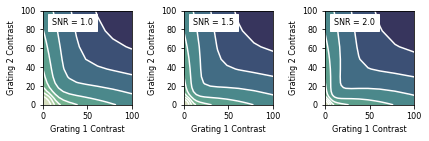

In [9]:
#SNR = ["0.5","0.75","1.0","1.5","2.0"]

SNR = ["1.0","1.5","2.0"]
import seaborn as sns
#Cross-Orientation suppression

noisy_COS_V = np.array([np.array(utils.fetch_file("./model_files/model_file_18/"+tag+"responses_0.5_2_{}_COS_rot_1.0.pkl".format(snr))) for snr in SNR])
print(noisy_COS_V.shape)
c = np.concatenate([[0],np.logspace(0,2,20)])

noisy_COS_rot_response = np.reshape(resp(noisy_COS_V,meanax = (1)),[len(SNR),21,21])

noisy_COS_rot_response = (noisy_COS_rot_response.transpose([0,2,1]) + noisy_COS_rot_response)/2

nm = np.min(noisy_COS_rot_response)
nmax = np.max(noisy_COS_rot_response)
l = np.linspace(nm,nmax,10)

print(noisy_COS_rot_response.shape)

fig, sub = plt.subplots(1,len(SNR),figsize = (2*len(SNR),2))

fcol = [(0,np.cos(x),np.sin(x),1) for x in np.linspace(np.pi/2,0,len(l))]
fcol = sns.cubehelix_palette(len(l), start=.5, rot=-.75)
for a in range(len(noisy_COS_rot_response)):
    #sub[a].pcolor(c,c,noisy_COS_rot_response[a],linewidth = 0)
    sub[a].contour(c,c,noisy_COS_rot_response[a],l,colors = [(1,1,1,1) for k in l])
    sub[a].contourf(c,c,noisy_COS_rot_response[a],l,colors = fcol)
    sub[a].text(.1,.85,"SNR = {}".format(SNR[a]),transform=sub[a].transAxes,color = (0,0,0,1),backgroundcolor = (1,1,1,1))
    sub[a].set_xlabel("Grating 1 Contrast")
    sub[a].set_ylabel("Grating 2 Contrast")
plt.tight_layout()
plt.savefig("./new_nMGSM_figures/non_trial_averaged_cos_rot.pdf",bbox_inches = "tight")
plt.show()

In [4]:
'''
fig = plt.figure(figsize = (onep5, onep5*1.25))

ax11 = plt.subplot2grid((5,6),(0,0),rowspan = 2,colspan = 3)
ax12 = plt.subplot2grid((5,6),(0,3),rowspan = 2,colspan = 3)
ax21 = plt.subplot2grid((5,6),(2,0),rowspan = 2,colspan = 3)
ax22 = plt.subplot2grid((5,6),(2,3),rowspan = 2,colspan = 3)

sub = np.array([[ax11,ax12],[ax21,ax22]])

axw1 = plt.subplot2grid((5,6),(4,0),rowspan = 2,colspan = 2)
axw2 = plt.subplot2grid((5,6),(4,2),rowspan = 2,colspan = 2)
axw3 = plt.subplot2grid((5,6),(4,4),rowspan = 2,colspan = 2)
'''

fig = plt.figure(figsize = (twocol,twocol/1.5))

ax11 = plt.subplot2grid((6,6),(0,0),rowspan = 3,colspan = 2)
ax12 = plt.subplot2grid((6,6),(3,0),rowspan = 3,colspan = 2)
ax21 = plt.subplot2grid((6,6),(0,2),rowspan = 3,colspan = 2)
ax22 = plt.subplot2grid((6,6),(3,2),rowspan = 3,colspan = 2)

sub = np.array([[ax11,ax12],[ax21,ax22]])

axw1 = plt.subplot2grid((6,6),(0,4),rowspan = 2,colspan = 2)
axw2 = plt.subplot2grid((6,6),(2,4),rowspan = 2,colspan = 2)
axw3 = plt.subplot2grid((6,6),(4,4),rowspan = 2,colspan = 2)

SNR = ["0.5","1.0","2.0"]

#Cross-Orientation suppression

noisy_COS_V = np.array([np.array(utils.fetch_file("./model_files/model_file_18/"+tag+"TA_responses_0.5_2_{}_COS_1.0.pkl".format(snr))) for snr in SNR])
clean_COS_V = np.array(utils.fetch_file("./model_files/model_file_18/"+tag+"nonoise_responses_0.5_1_1.0_COS_1.0.pkl"))

print(noisy_COS_V.shape)

noisy_COS_response = np.reshape(resp(noisy_COS_V,meanax = (1,2)),[len(SNR),20,3])
clean_COS_response = np.reshape(resp(clean_COS_V,meanax = (0)),[20,3])

noisy_COS_std = np.reshape(v_std(noisy_COS_V,meanax = (1,2)),[len(SNR),20,3,2])
clean_COS_std = np.reshape(v_std(clean_COS_V,meanax = (0)),[20,3,2])

def AI(f):
    a = np.reshape(resp(f,meanax = (1,2)),[len(SNR),20,3])
    b = a[:,:,0]/(a[:,:,1] + a[:,:,2])
    return b

def VAR(f):
    return np.reshape(v_std(f,meanax = (1,2)),[len(SNR),20,3,2])**2

noisy_AI_std = boot_f(AI,noisy_COS_V)
noisy_var_std = boot_f(VAR,noisy_COS_V)

print(noisy_AI_std.shape)
c = np.logspace(0,2,20)

clean_AI = clean_COS_response[:,0]/(clean_COS_response[:,1] + clean_COS_response[:,2])
noisy_AI = noisy_COS_response[:,:,0]/(noisy_COS_response[:,:,1] + noisy_COS_response[:,:,2])

#fig,sub = plt.subplots(2,2,figsize = (onep5,onep5))

sub[0,0].plot(c,clean_AI,"--",color = (0,0,0,.5))

colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(noisy_AI))]
for k in range(len(noisy_AI)):
    sub[0,0].plot(c,noisy_AI[k],color = colors[k],label = "{}".format(SNR[k]))
    sub[0,0].fill_between(c,noisy_AI[k] - noisy_AI_std[k],noisy_AI[k] + noisy_AI_std[k],color = trans(colors[k]))
    
sub[0,0].plot(c,np.ones_like(c),"k--")
    
sub[0,0].legend(loc = (.6,.6),framealpha = 1,title = "SNR",fontsize = 5)

sub[0,0].set_xlabel("contrast")
sub[0,0].set_ylabel("A.I.")
#sub[0,0].set_xscale("log")
sub[0,0].set_ylim([.5,1.25])
print(noisy_COS_std.shape)
sub[0,1].plot(c,noisy_COS_std[1,:,1,0]**2,color = colors[0],label = "Mask")
fill_between(sub[0,1],c,noisy_COS_std[1,:,1,0]**2,noisy_var_std[1,:,1,0],colors[0])

sub[0,1].plot(c,noisy_COS_std[1,:,2,0]**2,color = colors[-1],label = "Target")
fill_between(sub[0,1],c,noisy_COS_std[1,:,2,0]**2,noisy_var_std[1,:,2,0],colors[-1])
sub[0,1].text(.5,.9,"SNR = {}".format(SNR[1]),transform=sub[0,1].transAxes)
sub[0,1].set_ylabel("Voltage Variance")
sub[0,1].set_xlabel("Contrast")
sub[0,1].set_ylim([0,1.5])
sub[0,1].legend(loc = (.5,.7),framealpha = 1,fontsize = 5)

noisy_COS_rot_V = np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_1.0_COS_rot_1.0.pkl"))
clean_COS_rot_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_COS_rot_1.0.pkl"))

print(noisy_COS_rot_V.shape)

from scipy.ndimage.filters import gaussian_filter as gfilt

c = np.concatenate([[0],np.logspace(0,2,20)])
c2 = np.concatenate([[0],np.logspace(0,2,20)])

noisy_COS_rot_response = symm(np.reshape(resp(noisy_COS_rot_V,meanax = (0,1)),[21,21]))
clean_COS_rot_response = symm(np.reshape(resp(clean_COS_rot_V,meanax = (0)),[21,21]))

#noisy_COS_rot_response = gfilt(noisy_COS_rot_response,.75)
#clean_COS_rot_response = gfilt(clean_COS_rot_response,.75)

ln = np.linspace(np.min(noisy_COS_rot_response), np.max(noisy_COS_rot_response),10)
lc = np.linspace(np.min(clean_COS_rot_response), np.max(clean_COS_rot_response),10)

lcol = [(1,1,1,1) for x in np.linspace(1,.25,len(lc))]

#fcol = [(0,np.cos(x),np.sin(x),1) for x in np.linspace(np.pi/2,0,len(ln))]
fcol = sns.cubehelix_palette(len(ln), start=.5, rot=-.75)

#pcol = sub[1,0].pcolormesh(c2,c2,noisy_COS_rot_response,linewidth = 0)
#pcol.set_edgecolor('face')
sub[1,0].contour(c2,c2,noisy_COS_rot_response,ln,colors = lcol)
sub[1,0].contourf(c2,c2,noisy_COS_rot_response,ln,colors = fcol)
sub[1,0].set_xlabel("Grating 1 Contrast")
sub[1,0].set_ylabel("Grating 2 Contrast")
sub[1,0].text(40,95,"SNR = 1.0",bbox = {"edgecolor":(0,0,0,1),"facecolor":(1,1,1,1)})

#pcol = sub[1,1].pcolormesh(c,c,clean_COS_rot_response,linewidth = 0)
#pcol.set_edgecolor('face')
sub[1,1].contour(c,c,clean_COS_rot_response,lc,colors = lcol)
sub[1,1].contourf(c,c,clean_COS_rot_response,lc,colors = fcol)
sub[1,1].set_xlabel("Grating 1 Contrast")
sub[1,1].set_ylabel("Grating 2 Contrast")
sub[1,1].text(40,95,"Noiseless",bbox = {"edgecolor":(0,0,0,1),"facecolor":(1,.5,.5,1)})

dx = .16
dd = .1

subax = fig.add_axes([.66 - dx,1 - dx * 3/2,dd,dd * 3/2])
ii = -1
#pcol = subax.pcolormesh(c2[:ii],c2[:ii],noisy_COS_rot_response[:ii,:ii],linewidth = 0)
#pcol.set_edgecolor('face')
subax.contour(c2[:ii],c2[:ii],noisy_COS_rot_response[:ii,:ii],lc,colors = lcol)
subax.contourf(c2[:ii],c2[:ii],noisy_COS_rot_response[:ii,:ii],lc,colors = fcol)
subax.set_ylim([0,30])
subax.set_xlim([0,30])
subax.set_yticks([0,10,20])
subax.set_yticklabels(["0","10","20"])
subax.set_xticks([0,10,20])
subax.set_xticklabels(["0","10","20"])

subax = fig.add_axes([.66 - dx,.5 - dx * 3/2,dd,dd * 3/2])
ii = -1
#pcol = subax.pcolormesh(c[:ii],c[:ii],clean_COS_rot_response[:ii,:ii],linewidth = 0)#,lc,colors = lcol)
#pcol.set_edgecolor('face')
subax.contour(c[:ii],c[:ii],clean_COS_rot_response[:ii,:ii],lc,colors = lcol)
subax.contourf(c[:ii],c[:ii],clean_COS_rot_response[:ii,:ii],lc,colors = fcol)
subax.set_ylim([0,30])
subax.set_xlim([0,30])
subax.set_yticks([0,10,20])
subax.set_yticklabels(["0","10","20"])
subax.set_xticks([0,10,20])
subax.set_xticklabels(["0","10","20"])


sub[0,0].text(-.1,1.1,"A",transform=sub[0,0].transAxes,fontsize = 12)
sub[0,1].text(-.1,1.1,"B",transform=sub[0,1].transAxes,fontsize = 12)
sub[1,0].text(-.1,1.1,"C",transform=sub[1,0].transAxes,fontsize = 12)
sub[1,1].text(-.1,1.1,"D",transform=sub[1,1].transAxes,fontsize = 12)

axw1.text(-.1,1 + .1*3/2,"E",transform=axw1.transAxes,fontsize = 12)
axw2.text(-.1,1 + .1*3/2,"F",transform=axw2.transAxes,fontsize = 12)
axw3.text(-.1,1 + .1*3/2,"G",transform=axw3.transAxes,fontsize = 12)


sub = np.array([axw1,axw2,axw3])

def rot90(x):
    y = np.concatenate([x,x[:1]])
    return np.roll(y,1+len(y)/4)
noisy_WTA_V = np.array(utils.fetch_file("./model_files/model_file_18/"+tag+"TA_responses_0.5_2_1.5_WTA_1.0.pkl"))
clean_WTA_V = np.array(utils.fetch_file("./model_files/model_file_18/"+tag+"nonoise_responses_0.5_1_1.0_WTA_1.0.pkl"))

def WTA_resp(f,meanax,shape):
    return np.reshape(resp(f,meanax = meanax),shape)

print(noisy_WTA_V.shape)
print(2*20*5)
noisy_WTA = WTA_resp(noisy_WTA_V,meanax = (0,1),shape = [20,6,2])
clean_WTA = WTA_resp(clean_WTA_V,meanax = (0),shape = [20,6,2])

noisy_WTA_std = boot_f(lambda x:WTA_resp(x,0,[20,6,2]),noisy_WTA_V) 

a = np.linspace(0,np.pi,clean_WTA.shape[0]+1)

cind = [-1,4,2]
c = ["0","5.0","10.0","25.0","50.0","100.0"]
for k in range(3):
    sub[k].plot(a,rot90(noisy_WTA[:,0,1]),color = (0,.25,1,1))
    sub[k].plot(a,rot90(noisy_WTA[:,cind[k],0]),color = (0,.75,1,1))
    sub[k].plot(a,rot90(noisy_WTA[:,cind[k],1]),"k")
    
    fill_between(sub[k],a,rot90(noisy_WTA[:,0,1]),rot90(noisy_WTA_std[:,0,1]),color = (0,.25,1,1))
    fill_between(sub[k],a,rot90(noisy_WTA[:,cind[k],0]),rot90(noisy_WTA_std[:,cind[k],0]),color = (0,.75,1,1))
    fill_between(sub[k],a,rot90(noisy_WTA[:,cind[k],1]),rot90(noisy_WTA_std[:,cind[k],1]),(0,0,0,1))

    
    sub[k].text(0,12,"mask contrast = {}%".format(c[cind[k]]),fontsize = 8)
    sub[k].text(.2,1,"SNR = 1.5",fontsize = 8)
    sub[k].set_xticks([np.pi/4,3*np.pi/4])
    sub[k].set_xticklabels(["0","$\pi/2$"])
    sub[k].set_ylim([0,15])

#     sub[1,k].plot(a,rot90(clean_WTA[:,0,1]),"r--")
#     sub[1,k].plot(a,rot90(clean_WTA[:,cind[k],0]),"b--")
#     sub[1,k].plot(a,rot90(clean_WTA[:,cind[k],1]),"k--")
#     sub[1,k].set_xticks([np.pi/4,3*np.pi/4])
#     sub[1,k].set_xticklabels(["0","$\pi/2$"])
#     sub[1,k].set_ylim([0,15])

for s in sub:
    s.set_xlabel("Orientation")
    s.set_ylabel("Response")

atrial = noisy_COS_V.shape[1]
ctrial = noisy_COS_rot_V.shape[0]
etrial = noisy_WTA_V.shape[1]

plt.tight_layout()
plt.savefig("./new_nMGSM_figures/"+tag+"cross_orientatin_stimuli_AB-{}_C-{}_E-{}.pdf".format(atrial,ctrial,etrial),bbox_ionches = "tight")
plt.show()


IOError: [Errno 2] No such file or directory: './model_files/model_file_18/A-0.75_TA_responses_0.5_2_0.5_COS_1.0.pkl'

(3, 50, 1, 441, 2)
(1, 120, 16)


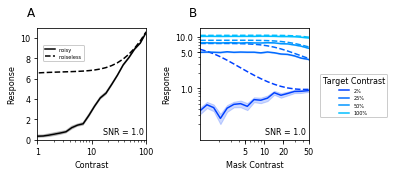

In [1178]:
SNR = ["0.5","1.0","2.0"]

noisy_full_COS_V = np.array([np.array(utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_{}_full_COS_1.0.pkl".format(snr))) for snr in SNR])
clean_full_COS_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_full_COS_1.0.pkl"))

print(noisy_full_COS_V.shape)

atrial = noisy_full_COS_V.shape[1]

noisy_full_COS = np.reshape(resp(noisy_full_COS_V,meanax = (1,2)),[len(SNR),21,21])
noisy_full_COS_std = np.reshape(resp_std(noisy_full_COS_V,meanax = (1,2)),[len(SNR),21,21])
clean_full_COS = np.reshape(resp(clean_full_COS_V,meanax = (0)),[21,21])

c = np.concatenate([[0],np.logspace(0,2,20)])

fig,sub = plt.subplots(1,2,figsize = (onep5,onep5/2))

sub[0].plot(c,noisy_full_COS[1,0,:],"k",label = "noisy")
sub[0].fill_between(c,noisy_full_COS[1,0,:]-noisy_full_COS_std[1,0,:],noisy_full_COS[1,0,:] + noisy_full_COS_std[1,0,:],color = trans((0,0,0,1)))
sub[0].plot(c,clean_full_COS[0,:],"k--",label = "noiseless")
sub[0].set_ylim([0,11])
sub[0].set_xlim([1,100])
sub[0].set_xscale("log")
sub[0].set_xticks([1,10,100])
sub[0].set_xticklabels(["1","10","100"])
sub[0].set_xlabel("Contrast")
sub[0].set_ylabel("Response")
sub[0].text(.6,.05,"SNR = {}".format(SNR[1]),backgroundcolor = (1,1,1,0),transform=sub[0].transAxes)
sub[0].legend(loc = (.05,.7),framealpha = 1,fontsize = 5)
##CARANDINI
carSNR = ["0.5","0.75","1.0","1.5","2.0"]

noisy_carandini_V = np.array([utils.fetch_file("./model_files/model_file_18/TA_responses_0.5_2_{}_carandini_rep_1.0.pkl".format(s)) for s in carSNR])
clean_carandini_V = np.array(utils.fetch_file("./model_files/model_file_18/nonoise_responses_0.5_1_1.0_carandini_rep_1.0.pkl"))
btrial = noisy_carandini_V.shape[1]

print(clean_stiff_carandini_V.shape)
c = np.logspace(0,2,20)
noisy_carandini = np.reshape(resp(noisy_carandini_V,meanax = (1,2)),[len(carSNR),20,6])
noisy_carandini_std = np.reshape(resp_std(noisy_carandini_V,meanax = (1,2)),[len(carSNR),20,6])
clean_carandini = np.reshape(resp(clean_carandini_V,meanax = (0)),[20,6])

mc = [2,5,10,25,50,100]

ind = [0,-3,-2,-1]

colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(ind))]
colors_a = [(0,x,1,.2) for x in np.linspace(.25,.75,len(ind))]

for k in ind:
    sub[1].plot(c,noisy_carandini[1,:,k],label = "{}%".format(mc[k]),color = colors[k])
    sub[1].fill_between(c,noisy_carandini[1,:,k]- noisy_carandini_std[1,:,k],noisy_carandini[1,:,k]+ noisy_carandini_std[1,:,k],color = trans(colors[k]))
    
    sub[1].plot(c,clean_carandini[:,k],"--",color = colors[k]) 
   
sub[1].set_xscale("log")
sub[1].set_yscale("log")

sub[1].set_xticks([5,10,20,50])
sub[1].set_xticklabels(["5","10","20","50"])

sub[1].set_yticks([1,5,10])
sub[1].set_yticklabels(["1.0","5.0","10.0"])

sub[1].set_xlabel("Mask Contrast")
sub[1].set_ylabel("Response")
sub[1].set_xlim([1,50])
sub[1].set_ylim([.1,15])
sub[1].text(.6,.05,"SNR = 1.0",backgroundcolor = (1,1,1,0),transform=sub[1].transAxes)

sub[1].legend(loc = (1.1,.2),title = "Target Contrast",framealpha=1,fontsize = 5)

sub[0].text(-.1,1.1,"A",transform=sub[0].transAxes,fontsize = 12)
sub[1].text(-.1,1.1,"B",transform=sub[1].transAxes,fontsize = 12)


plt.tight_layout()
plt.savefig("./new_nMGSM_figures/CRF_carandini_rep_A-{}_B-{}.pdf".format(atrial,btrial),bbox_inches = "tight")

plt.show()

(5, 1, 120, 2)
(5, 20, 6)


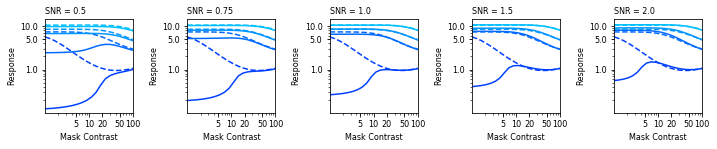

In [1133]:
SNR = ["0.5","0.75","1.0","1.5","2.0"]

noisy_carandini_V = np.array([utils.fetch_file("./model_files/model_file_18/responses_0.5_2_{}_carandini_rep_1.0.pkl".format(s)) for s in carSNR])
N = noisy_carandini_V.shape[1]

print(noisy_carandini_V.shape)
c = np.logspace(0,2,20)
noisy_carandini = np.reshape(resp(noisy_carandini_V,meanax = (1)),[len(carSNR),20,6])
print(noisy_carandini.shape)

fig, sub = plt.subplots(1,len(SNR),figsize = (2*len(SNR),2))
ind = [0,-3,-2,-1]

colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(ind))]
colors_a = [(0,x,1,.2) for x in np.linspace(.25,.75,len(ind))]

for a in range(len(noisy_carandini)):
    for b in ind:
        sub[a].plot(c,noisy_carandini[a,:,b],color = colors[b])
        sub[a].plot(c,clean_carandini[:,b],"--",color = colors[b]) 
        
    sub[a].text(0,1.05,"SNR = {}".format(SNR[a]),transform=sub[a].transAxes)
    
    sub[a].set_yscale("log")
    sub[a].set_xscale("log")
    sub[a].set_xticks([5,10,20,50,100])
    sub[a].set_xticklabels(["5","10","20","50","100"])

    sub[a].set_yticks([1,5,10])
    sub[a].set_yticklabels(["1.0","5.0","10.0"])

    sub[a].set_xlabel("Mask Contrast")
    sub[a].set_ylabel("Response")
    sub[a].set_xlim([1,100])
    sub[a].set_ylim([.1,15])
    

plt.tight_layout()
plt.savefig("./new_nMGSM_figures/non_trial_averaged_carandini_rep.pdf",bbox_inches = "tight")
plt.show()

# MGSM

- Size Tuning
- Surround Suppression

In [6]:
SNR = ["1.0","1.5","2.0"]
SNRf = [float(x) for x in SNR]

noisy_size_tuning_V = np.array([np.array(utils.fetch_file("./model_files/MGSM_model_file/TA_responses_0.5_2_{}_size_tuning_1.0.pkl".format(snr))) for snr in SNR])
clean_size_tuning_V = np.array(utils.fetch_file("./model_files/MGSM_model_file/nonoise_responses_0.5_1_1.0_size_tuning_1.0.pkl".format(snr)))
noisy_size_tuning_V.shape

def ST(f):
    return np.reshape(resp(f,meanax = (1,2)),[len(SNR),20,11])

noisy_size_tuning = ST(noisy_size_tuning_V)
noisy_size_tuning_std = boot_f(ST,noisy_size_tuning_V)
clean_size_tuning = np.reshape(resp(clean_size_tuning_V,meanax = (0)),[20,11])

def SI(x):
    y = x/np.max(x)
    
    return 1. - y[-1]

def full_SI(f):
    a = np.reshape(resp(f,meanax = (1,2)),[len(SNR),20,11])
    return np.array([[SI(y) for y in x] for x in np.transpose(a,[0,2,1])])

def sum_size(f):
    a = np.reshape(resp(f,meanax = (1,2)),[len(SNR),20,11])
    return np.array([[np.argmax(y) for y in x] for x in np.transpose(a,[0,2,1])])
    
print(clean_size_tuning[:,1])

noisy_SI = full_SI(noisy_size_tuning_V)
noisy_SI_std = boot_f(full_SI,noisy_size_tuning_V)

clean_SI = np.array([SI(y) for y in np.transpose(clean_size_tuning)])

noisy_SZ = sum_size(noisy_size_tuning_V)
noisy_SZ_std = boot_f(sum_size,noisy_size_tuning_V)

clean_SZ = np.array([np.argmax(y) for y in np.transpose(clean_size_tuning)])
print(clean_SI)

#fig,sub = plt.subplots(2,2,figsize = (onep5,onep5))
fig,sub = plt.subplots(2,2,figsize = (onecol,onecol))

sub = np.reshape(sub,[-1])

cc = np.linspace(0,100,len(clean_SI))
ccn = np.linspace(0,100,len(noisy_SI[0]))

stc = np.linspace(0,100,11)

STind = 2
ind = [1,3,5,10]
colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(ind))]
x = np.linspace(0,1,noisy_size_tuning.shape[1])
for i in range(len(ind)):
    sub[0].plot(x,noisy_size_tuning[STind,:,ind[i]],color = colors[i],label = "{}%".format(int(stc[ind[i]])))
    fill_between(sub[0],x,noisy_size_tuning[STind,:,ind[i]],noisy_size_tuning_std[STind,:,ind[i]],color = colors[i])
    sub[0].plot(x,clean_size_tuning[:,ind[i]],"--",color = colors[i])
sub[0].set_xlabel("Grating Size")
sub[0].set_ylabel("Response")
sub[0].text(.5,0,"SNR = {}".format(SNR[STind]),fontsize = 5)
sub[0].legend(loc = (.6,.65),title = "Contrast",framealpha = 1,fontsize = 5)

sub[1].plot(cc[1:],clean_SI[1:],"--",color = (0,0,0,.5))
SIind = [0,2,3]
colors = [(0,x,1,1) for x in np.linspace(.25,.75,len(SIind))]
for k in range(len(SIind)):
    sub[1].plot(ccn[1:],noisy_SI[SIind[k]][1:],label = "{}".format(SNR[SIind[k]]),color = colors[k])
    fill_between(sub[1],ccn[1:],noisy_SI[SIind[k]][1:],noisy_SI_std[SIind[k]][1:],color = colors[k])
sub[1].legend(loc = (.6,.7),title = "SNR",framealpha = 1,fontsize = 5)
sub[1].set_ylim([0,.7])
sub[1].set_xlabel("Contrast")
sub[1].set_ylabel("S.I.")

ssSNR = ["0.5","0.75","1.0","2.0"]

def SS(f):
    return np.reshape(resp(f,meanax = (1,2)),[len(ssSNR),20,2])
noisy_surrond_suppression_V = np.array([utils.fetch_file("./model_files/MGSM_model_file/"+tag+"TA_responses_0.5_2_{}_surround_suppression_1.0.pkl".format(s)) for s in ssSNR])
clean_surrond_suppression_V = np.array(utils.fetch_file("./model_files/MGSM_model_file/"+tag+"nonoise_responses_0.5_1_1.0_surround_suppression_1.0.pkl".format(snr)))

noisy_surrond_suppression = SS(noisy_surrond_suppression_V)
noisy_surrond_suppression_std = boot_f(SS,noisy_surrond_suppression_V)
clean_surrond_suppression = np.reshape(resp(clean_surrond_suppression_V,meanax = (0)),[20,2])

c = np.logspace(0,2,clean_surrond_suppression.shape[0])

sub[2].plot(c,clean_surrond_suppression[:,0],"--",color = (0,.25,1,1))
sub[2].plot(c,clean_surrond_suppression[:,1],"--",color = (0,.75,1,1))
sub[2].plot(c,noisy_surrond_suppression[2,:,0],label = "off",color = (0,.25,1,1))
sub[2].plot(c,noisy_surrond_suppression[2,:,1],label = "on",color = (0,.75,1,1))

fill_between(sub[2],c,noisy_surrond_suppression[2,:,0],noisy_surrond_suppression_std[0,:,0],color = (0,.25,1,1))
fill_between(sub[2],c,noisy_surrond_suppression[2,:,1],noisy_surrond_suppression_std[0,:,1],color = (0,.75,1,1))

sub[2].text(12,0,"SNR = {}".format(ssSNR[2]),fontsize = 5)
sub[2].set_xscale("log")
sub[2].set_xticks([1,10,100])
sub[2].set_xticklabels([1,10,100])
sub[2].legend(title = "Surround",fontsize = 5)
sub[2].set_xlabel("Center Contrast")
sub[2].set_ylabel("Response")

for k in range(len(SIind)):
    sub[3].plot(ccn,noisy_SZ[SIind[k]],label = "{}".format(SNR[SIind[k]]),color = colors[k])
    fill_between(sub[3],ccn,noisy_SZ[SIind[k]],noisy_SZ_std[SIind[k]],color = colors[k])

sub[3].plot(ccn,clean_SZ,"--",color = (0,.25,1,1))

sub[3].set_xscale("log")
sub[3].set_yscale("log")
sub[3].set_xticks([1,10,100])
sub[3].set_xticklabels([1,10,100])
sub[3].set_yticks([1,2,10])
sub[3].set_yticklabels([1,2,10])
sub[3].legend(loc = (.6,.7),title = "SNR",framealpha = 1,fontsize = 5)
sub[3].set_xlabel("Contrast")
sub[3].set_ylabel("Summation Size")


sub[0].text(-.1,1.1,"A",transform=sub[0].transAxes,fontsize = 12)
sub[1].text(-.1,1.1,"B",transform=sub[1].transAxes,fontsize = 12)
sub[2].text(-.1,1.1,"C",transform=sub[2].transAxes,fontsize = 12)
sub[3].text(-.1,1.1,"D",transform=sub[3].transAxes,fontsize = 12)

atrial = noisy_size_tuning_V.shape[1]
ctrial = noisy_surrond_suppression_V.shape[1]

plt.tight_layout()
plt.savefig("./new_nMGSM_figures/MGSM_stimuli_ABD-{}_C-{}.pdf".format(atrial,ctrial),bbox_inches = "tight")

plt.show()

IOError: [Errno 2] No such file or directory: './model_files/MGSM_model_file/TA_responses_0.5_2_1.5_size_tuning_1.0.pkl'

In [1185]:
RES=np.array(utils.fetch_file("./model_files/model_file_26/responses_0.5_2_0.5_size_tuning_1.0.pkl"))

In [1186]:
print(RES.shape)

(1, 220, 2)


0.0
3.47796763486e-05
0.000140185850315
0.00747963638031
0.110305251388
0.214865451495
0.283641385685
0.33040269304
0.353286637162
0.365314352906
0.372065670193


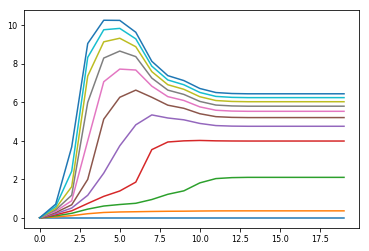

In [1187]:
RES = np.reshape(RES,[20,11,2])

for k in range(RES.shape[1]):
    plt.plot(RES[:,k,0])
    print(SI(RES[:,k,0]))
plt.show()


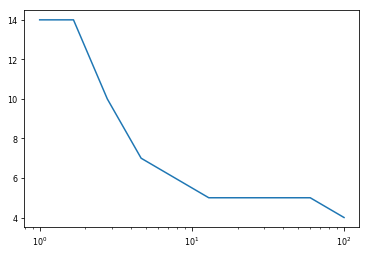

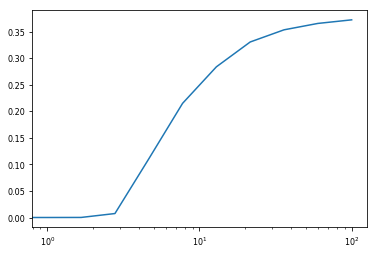

In [1188]:
sumsize = [np.argmax(RES[:,k,0]) for k in range(RES.shape[1])]
supind= [SI(RES[:,k,0]) for k in range(RES.shape[1])]
c = np.concatenate([[0],np.logspace(0,2,10)])
plt.plot(c[1:],sumsize[1:])
plt.xscale("log")
plt.show()
plt.plot(c,supind)
plt.xscale("log")
plt.show()